In [6]:

#  IMPORTS & CONFIGURATION
import os
import time
import json
import re
import pickle
from collections import Counter

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm

# --- ADVANCED PARSER ---
import trafilatura

# --- VISUALIZATION LIBS ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLP LIBS ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import textstat
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ne_chunk, pos_tag, word_tokenize

# --- Download NLTK data (silently) ---
print("Downloading NLTK assets (one-time setup)...")
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

print("All libraries imported and NLTK assets are ready.")

All libraries imported and NLTK assets are ready.


In [7]:
#  DEFINE FILE PATHS
DATA_DIR = 'data'
MODELS_DIR = 'models'

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Input
INPUT_CSV = os.path.join(DATA_DIR, 'data.csv')

# Outputs
EXTRACTED_CSV = os.path.join(DATA_DIR, 'extracted_content.csv')
FEATURES_ADVANCED_CSV = os.path.join(DATA_DIR, 'features_advanced.csv') # Final features
DUPLICATES_CSV = os.path.join(DATA_DIR, 'duplicates.csv')
EMBEDDINGS_FILE = os.path.join(DATA_DIR, 'embeddings.npz')

# Model files
VECTORIZER_FILE = os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl')
MODEL_FILE = os.path.join(MODELS_DIR, 'quality_model.pkl')

print(f"Data directory: {os.path.abspath(DATA_DIR)}")
print(f"Models directory: {os.path.abspath(MODELS_DIR)}")

Data directory: C:\Users\Admin\Desktop\seo-content-detector\notebooks\data
Models directory: C:\Users\Admin\Desktop\seo-content-detector\notebooks\models


In [8]:
#  (UPGRADED): HTML PARSING & SCRAPING UTILITIES
# Using 'trafilatura' for superior text extraction
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
HEADERS = {'User-Agent': USER_AGENT}


def fetch_html(url, timeout=10, delay=1.5):
    """Fetch HTML with basic rate limiting and error handling."""
    # print(f"Fetching (Scraping): {url}") # Make this quiet for the demo
    try:
        time.sleep(delay) 
        resp = requests.get(url, headers=HEADERS, timeout=timeout)
        resp.raise_for_status()
        return resp.text
    except Exception as e:
        print(f"  -> Failed to fetch {url}: {e}")
        return None


def extract_title_and_body(html):
    """
    Extract title and main body text using the advanced 'trafilatura' library.
    """
    try:
        # 1. Let trafilatura find the main content block
        body_text = trafilatura.extract(
            html, 
            include_comments=False, 
            include_tables=False,
            deduplicate=True
        )
        
        if not body_text:
            return None, None 

        # 2. Extract Title (BeautifulSoup is still good for this)
        soup = BeautifulSoup(html, 'html.parser')
        title = None
        if soup.title and soup.title.string:
            title = soup.title.string.strip()

        # 3. Clean up whitespace
        body_text = re.sub(r'\s+', ' ', body_text).strip()
        
        return title, body_text
    
    except Exception as e:
        print(f"  -> HTML Parse error: {e}")
        return None, None

print("Utility functions `fetch_html` and ADVANCED `extract_title_and_body` defined.")

Utility functions `fetch_html` and ADVANCED `extract_title_and_body` defined.


In [10]:
#  STEP 1 - DATA COLLECTION & HTML PARSING
print(f"Starting Step 1: Data Collection & Parsing")

if os.path.exists(EXTRACTED_CSV):
    print(f"Found existing file, loading from: {EXTRACTED_CSV}")
    extracted_df = pd.read_csv(EXTRACTED_CSV)
else:
    print(f"No pre-extracted file found. Parsing from source: {INPUT_CSV}")
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print(f"ERROR: Input file not found at {INPUT_CSV}")
        print("Please download the dataset and place it in the 'data/' directory.")
        raise

    USE_HTML_COLUMN = 'html_content' in df.columns
    
    if USE_HTML_COLUMN:
        print("Detected 'html_content' column. Parsing from column...")
    else:
        print("No 'html_content' column. Will scrape URLs (this will be slow)...")

    rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Parsing/Scraping"):
        url = row.get('url')
        html = None

        if USE_HTML_COLUMN and pd.notna(row['html_content']):
            html = row['html_content']
        else:
            html = fetch_html(url)

        if not html:
            continue
            
        title, body = extract_title_and_body(html)
        
        if not body:
            continue

        word_count = len(body.split())
        
        if word_count > 10: # Only add rows with meaningful text
            rows.append({
                'url': url, 
                'title': title, 
                'body_text': body, 
                'word_count': word_count
            })

    extracted_df = pd.DataFrame(rows)
    extracted_df.to_csv(EXTRACTED_CSV, index=False)
    print(f"\nSaved extracted content to {EXTRACTED_CSV} ({len(extracted_df)} rows)")

print("\nExtracted Data Sample:")
extracted_df.head()

Starting Step 1: Data Collection & Parsing
No pre-extracted file found. Parsing from source: data\data.csv
Detected 'html_content' column. Parsing from column...


Parsing/Scraping:   6%|████                                                             | 5/81 [00:02<00:37,  2.02it/s]

  -> Failed to fetch https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips: 403 Client Error: Forbidden for url: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips


Parsing/Scraping:  23%|███████████████                                                 | 19/81 [00:17<02:33,  2.47s/it]

  -> Failed to fetch https://www.hpe.com/us/en/what-is/sd-wan.html: HTTPSConnectionPool(host='www.hpe.com', port=443): Read timed out. (read timeout=10)


Parsing/Scraping:  30%|██████████████████▉                                             | 24/81 [00:22<01:22,  1.45s/it]

  -> Failed to fetch https://www.cloudflare.com/learning/access-management/what-is-ztna/: 403 Client Error: Forbidden for url: https://www.cloudflare.com/learning/access-management/what-is-ztna/


Parsing/Scraping:  49%|███████████████████████████████▌                                | 40/81 [00:24<00:04,  8.38it/s]

  -> Failed to fetch https://towardsdatascience.com/machine-learning-basics-with-examples-part-1-c2d37247ec3d: 403 Client Error: Forbidden for url: https://towardsdatascience.com/machine-learning-basics-with-examples-part-1-c2d37247ec3d


Parsing/Scraping:  54%|██████████████████████████████████▊                             | 44/81 [00:29<00:23,  1.60it/s]

  -> Failed to fetch https://www.analyticsvidhya.com/blog/2021/09/comprehensive-guide-on-machine-learning/: 404 Client Error: Not Found for url: https://www.analyticsvidhya.com/blog/2021/09/comprehensive-guide-on-machine-learning/


Parsing/Scraping:  65%|█████████████████████████████████████████▉                      | 53/81 [00:32<00:14,  1.92it/s]

  -> Failed to fetch https://www.investopedia.com/terms/s/seo.asp: 404 Client Error: Not Found for url: https://www.investopedia.com/terms/s/seo.asp


Parsing/Scraping:  94%|████████████████████████████████████████████████████████████    | 76/81 [00:44<00:03,  1.52it/s]

  -> Failed to fetch https://www.reuters.com/technology/artificial-intelligence/: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/technology/artificial-intelligence/


Parsing/Scraping:  95%|████████████████████████████████████████████████████████████▊   | 77/81 [00:48<00:05,  1.33s/it]

  -> Failed to fetch https://www.cnbc.com/artificial-intelligence/: 404 Client Error: Not Found for url: https://www.cnbc.com/artificial-intelligence/


Parsing/Scraping:  98%|██████████████████████████████████████████████████████████████▍ | 79/81 [00:50<00:02,  1.12s/it]

  -> Failed to fetch https://www.bbc.com/news/topics/c404v061z99t: 404 Client Error: Not Found for url: https://www.bbc.com/news/topics/c404v061z99t


Parsing/Scraping: 100%|████████████████████████████████████████████████████████████████| 81/81 [00:51<00:00,  1.59it/s]


Saved extracted content to data\extracted_content.csv (70 rows)

Extracted Data Sample:


,url,title,body_text,word_count
0,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1652
1,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,11 Cyber Defense Tips to Stay Secure at Work a...,1038
2,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices Cyberspace is par...,561
3,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,"Every week, networks seem to grow in size and ...",2083
4,https://www.fortinet.com/resources/cyberglossa...,What Is Network Security? Definition and Types...,What Is Network Security? Discover the types o...,1996


In [11]:
#  STEP 2a - CORE FEATURE ENGINEERING
# (Readability, Keywords, TF-IDF)
print("Starting Step 2a: Core Feature Engineering")

# Load the clean, extracted data
df = pd.read_csv(EXTRACTED_CSV).dropna(subset=['body_text'])

# 1. Clean text and basic metrics
print("Calculating basic metrics...")
df['clean_text'] = df['body_text'].str.lower().fillna('')
df['sentence_count'] = df['clean_text'].apply(lambda t: len(nltk.sent_tokenize(t)) if t else 0)

# 2. Readability
print("Calculating readability scores...")
df['flesch_reading_ease'] = df['clean_text'].apply(textstat.flesch_reading_ease)

# 3. TF-IDF Embeddings & Keywords (as allowed by assignment)
print("Calculating TF-IDF vectors and keywords...")
corpus = df['clean_text'].tolist()

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=2000, 
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# 4. Get Top 5 Keywords
print("Extracting top keywords...")
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_dense = tfidf_matrix.toarray()

def get_top_keywords(tfidf_row, feature_names, top_n=5):
    top_indices = tfidf_row.argsort()[-top_n:][::-1]
    keywords = [feature_names[i] for i in top_indices if tfidf_row[i] > 0]
    return "|".join(keywords)

df['top_keywords'] = [get_top_keywords(row, feature_names) for row in tfidf_dense]

# 5. Save core artifacts
print(f"Saving TF-IDF vectorizer to {VECTORIZER_FILE}")
with open(VECTORIZER_FILE, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print(f"Saving TF-IDF matrix (embeddings) to {EMBEDDINGS_FILE}")
# Save the sparse matrix, it's more efficient
from scipy.sparse import save_npz
save_npz(EMBEDDINGS_FILE, tfidf_matrix)

features_df = df # Rename for clarity
print("\nCore Feature Engineering Complete.")
features_df[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords']].head()

Starting Step 2a: Core Feature Engineering
Calculating basic metrics...
Calculating readability scores...
Calculating TF-IDF vectors and keywords...
Extracting top keywords...
Saving TF-IDF vectorizer to models\tfidf_vectorizer.pkl
Saving TF-IDF matrix (embeddings) to data\embeddings.npz

Core Feature Engineering Complete.


,url,word_count,sentence_count,flesch_reading_ease,top_keywords
0,https://www.varonis.com/blog/cybersecurity-tips,1652,89,41.331849,access|security|data|app|mfa
1,https://www.cisecurity.org/insights/blog/11-cy...,1038,61,53.688621,password|authentication|don|protect|use
2,https://www.cisa.gov/topics/cybersecurity-best...,561,22,3.706599,cybersecurity|cyber|practices|services|best pr...
3,https://nordlayer.com/learn/network-security/b...,2083,180,27.549043,network|security|monitoring|devices|access
4,https://www.fortinet.com/resources/cyberglossa...,1996,100,22.417055,network|security|network security|access|secure


Starting Step 2b: Advanced NLP Analysis (Bonus)...
Applying NLP functions to all articles...

✓ Advanced NLP features extracted.
Saving final feature set to data\features_advanced.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_9324\948363869.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=features_df, order=['Positive', 'Neutral', 'Negative'], palette="viridis")
C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

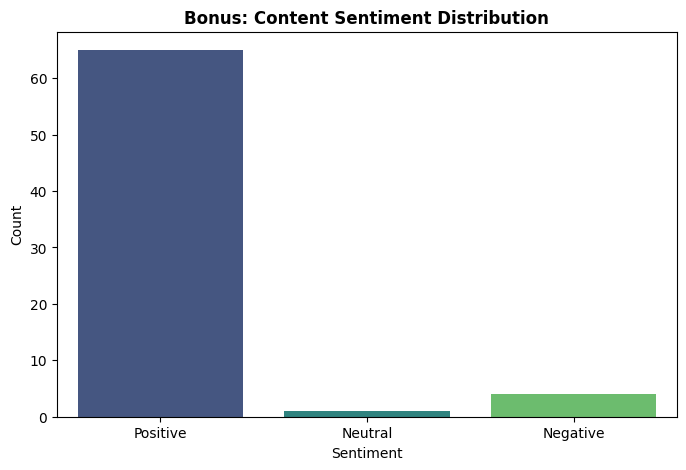


Sample of Advanced Features:


,url,sentiment_label,entity_count,noun_ratio
0,https://www.varonis.com/blog/cybersecurity-tips,Positive,16,0.283
1,https://www.cisecurity.org/insights/blog/11-cy...,Positive,24,0.250
2,https://www.cisa.gov/topics/cybersecurity-best...,Positive,36,0.407
3,https://nordlayer.com/learn/network-security/b...,Positive,42,0.371
4,https://www.fortinet.com/resources/cyberglossa...,Positive,32,0.337


In [12]:
#  STEP 2b - ADVANCED NLP FEATURES (+7 Points)
# (Sentiment, NER, POS Ratios)
print("Starting Step 2b: Advanced NLP Analysis (Bonus)...")

def advanced_nlp_analysis(text):
    """
    Perform advanced NLP analysis: sentiment, entities, POS tags
    """
    results = {}
    try:
        # 1. Sentiment Analysis
        sia = SentimentIntensityAnalyzer()
        sentiment = sia.polarity_scores(text)
        results['sentiment_compound'] = round(sentiment['compound'], 3)
        results['sentiment_label'] = 'Positive' if sentiment['compound'] > 0.05 else 'Negative' if sentiment['compound'] < -0.05 else 'Neutral'
        
        # 2. Named Entity Recognition
        tokens = word_tokenize(text[:5000]) # Limit text size for performance
        pos_tags = pos_tag(tokens)
        chunks = ne_chunk(pos_tags)
        
        entities = [chunk.label() for chunk in chunks if hasattr(chunk, 'label')]
        entity_counts = Counter(entities)
        results['entity_count'] = len(entities) # Total number of entities found
        
        # 3. POS Tag Distribution
        pos_counts = Counter([tag for word, tag in pos_tags])
        total_tags = max(1, len(pos_tags)) # Avoid zero division
        results['noun_ratio'] = round(sum([v for k, v in pos_counts.items() if k.startswith('NN')]) / total_tags, 3)
        results['verb_ratio'] = round(sum([v for k, v in pos_counts.items() if k.startswith('VB')]) / total_tags, 3)
        results['adj_ratio'] = round(sum([v for k, v in pos_counts.items() if k.startswith('JJ')]) / total_tags, 3)
        
    except Exception as e:
        # Return empty defaults on failure
        results = {'sentiment_compound': 0, 'sentiment_label': 'Unknown', 'entity_count': 0,
                   'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0}
    return pd.Series(results)

# Apply this function (this may take a minute)
print("Applying NLP functions to all articles...")
nlp_features_df = features_df['body_text'].apply(advanced_nlp_analysis)

# Merge new features into the main DataFrame
features_df = pd.concat([features_df, nlp_features_df], axis=1)

print("\n✓ Advanced NLP features extracted.")
print(f"Saving final feature set to {FEATURES_ADVANCED_CSV}")
features_df.to_csv(FEATURES_ADVANCED_CSV, index=False)

# --- Bonus Visualization: Sentiment ---
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=features_df, order=['Positive', 'Neutral', 'Negative'], palette="viridis")
plt.title('Bonus: Content Sentiment Distribution', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

print("\nSample of Advanced Features:")
features_df[['url', 'sentiment_label', 'entity_count', 'noun_ratio']].head()

In [13]:
#  STEP 3 - DUPLICATE & THIN CONTENT DETECTION
print("Starting Step 3: Duplicate & Thin Content Detection")

# --- Thin Content ---
features_df['is_thin'] = features_df['word_count'] < 500
thin_count = features_df['is_thin'].sum()
total_pages = len(features_df)
print(f"\n--- Thin Content Report ---")
print(f"Found {thin_count} thin content pages (Word Count < 500).")
print(f"Percentage: {thin_count / total_pages:.2%}")

# --- Duplicate Detection ---
print("\n--- Duplicate Content Report ---")
print("Computing cosine similarity matrix...")
# tfidf_matrix is from Cell 5
sim_matrix = cosine_similarity(tfidf_matrix)

SIMILARITY_THRESHOLD = 0.80
duplicate_pairs = []
urls = features_df['url'].tolist()
n = len(urls)

for i, j in zip(*np.triu_indices_from(sim_matrix, k=1)):
    if sim_matrix[i, j] >= SIMILARITY_THRESHOLD:
        duplicate_pairs.append({
            'url1': urls[i],
            'url2': urls[j],
            'similarity': sim_matrix[i, j]
        })

print(f"Found {len(duplicate_pairs)} duplicate pairs (Threshold > {SIMILARITY_THRESHOLD}).")

duplicates_df = pd.DataFrame(duplicate_pairs).sort_values(by='similarity', ascending=False)
duplicates_df.to_csv(DUPLICATES_CSV, index=False)
print(f"Saved duplicate pairs report to {DUPLICATES_CSV}")

duplicates_df.head()

Starting Step 3: Duplicate & Thin Content Detection

--- Thin Content Report ---
Found 26 thin content pages (Word Count < 500).
Percentage: 37.14%

--- Duplicate Content Report ---
Computing cosine similarity matrix...
Found 11 duplicate pairs (Threshold > 0.8).
Saved duplicate pairs report to data\duplicates.csv


,url1,url2,similarity
1,https://en.wikipedia.org/wiki/SD-WAN,https://www.fortinet.com/resources/cyberglossa...,0.893351
9,https://www.forbes.com/advisor/business/what-i...,https://blog.hubspot.com/marketing/what-is-dig...,0.843541
2,https://sign.dropbox.com/products/dropbox-fax,https://www.fax.plus/,0.833786
4,https://nytlicensing.com/latest/trends/content...,https://www.twilio.com/en-us/blog/insights/con...,0.833093
7,https://copyblogger.com/content-marketing/,https://mailchimp.com/marketing-glossary/conte...,0.831638


In [14]:
#  STEP 4a - MODEL LABELING & SPLIT
print("Starting Step 4: Content Quality Scoring")

def create_quality_labels(row):
    """Creates synthetic labels based on assignment rules."""
    wc, readability = row['word_count'], row['flesch_reading_ease']
    
    if (wc > 1500) and (50 <= readability <= 70): return 'High'
    if (wc < 500) or (readability < 30): return 'Low'
    return 'Medium'

print("Creating synthetic quality labels...")
features_df['quality_label'] = features_df.apply(create_quality_labels, axis=1)

# --- CRITICAL UPGRADE ---
# We now add our new NLTK features to the model
FEATURE_COLUMNS = [
    # Basic Features
    'word_count', 
    'sentence_count', 
    'flesch_reading_ease',
    # Advanced NLP Features
    'sentiment_compound',
    'entity_count',
    'noun_ratio',
    'verb_ratio',
    'adj_ratio'
]
TARGET_COLUMN = 'quality_label'

print(f"--- Model will train with {len(FEATURE_COLUMNS)} features ---")
print(FEATURE_COLUMNS)

X = features_df[FEATURE_COLUMNS].fillna(0) # Fill NaNs just in case
y = features_df[TARGET_COLUMN]

# --- CRITICAL: Check Label Distribution ---
print("\n--- Label Distribution ---")
print(y.value_counts(normalize=True))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nData split complete: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Starting Step 4: Content Quality Scoring
Creating synthetic quality labels...
--- Model will train with 8 features ---
['word_count', 'sentence_count', 'flesch_reading_ease', 'sentiment_compound', 'entity_count', 'noun_ratio', 'verb_ratio', 'adj_ratio']

--- Label Distribution ---
quality_label
Low       0.471429
Medium    0.400000
High      0.128571
Name: proportion, dtype: float64

Data split complete: X_train shape: (49, 8), X_test shape: (21, 8)



--- Baseline Model (Word Count Rule) ---
Baseline Accuracy: 0.6190

--- Random Forest Model (with Advanced Features) ---
Model Accuracy: 0.9048
Model F1-Score (Weighted): 0.9023

Classification Report (Random Forest):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         3
         Low       0.83      1.00      0.91        10
      Medium       1.00      0.75      0.86         8

    accuracy                           0.90        21
   macro avg       0.94      0.92      0.92        21
weighted avg       0.92      0.90      0.90        21


--- Top Features (from Advanced Model) ---
               feature  importance
2  flesch_reading_ease    0.253517
1       sentence_count    0.199027
0           word_count    0.161001
3   sentiment_compound    0.111624
5           noun_ratio    0.104606
6           verb_ratio    0.069065
4         entity_count    0.056878
7            adj_ratio    0.044282


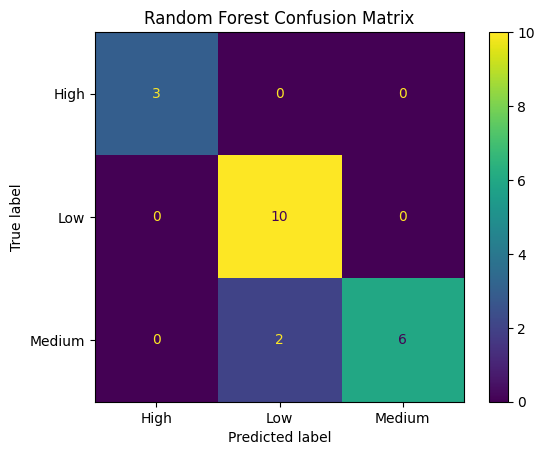


Saving model pipeline to models\quality_model.pkl


In [15]:
# STEP 4b - BASELINE & ML MODEL TRAINING

# --- 1. Baseline Model (Rule-based on word count) ---
print("\n--- Baseline Model (Word Count Rule) ---")
def baseline_classifier(word_count):
    if word_count < 500: return 'Low'
    if word_count > 1500: return 'High'
    return 'Medium'

y_pred_baseline = X_test['word_count'].apply(baseline_classifier)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

# --- 2. Advanced Random Forest Model ---
print("\n--- Random Forest Model (with Advanced Features) ---")
model_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
)
model_pipeline.fit(X_train, y_train)
y_pred_model = model_pipeline.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred_model)
print(f"Model Accuracy: {model_accuracy:.4f}")
print(f"Model F1-Score (Weighted): {f1_score(y_test, y_pred_model, average='weighted'):.4f}")

print("\nClassification Report (Random Forest):")
labels = sorted(y.unique())
print(classification_report(y_test, y_pred_model, labels=labels, zero_division=0))

# --- 3. Feature Importance ---
print("\n--- Top Features (from Advanced Model) ---")
rf_model = model_pipeline.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(feature_imp_df)

# --- 4. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_model, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# --- 5. Save the final model ---
print(f"\nSaving model pipeline to {MODEL_FILE}")
with open(MODEL_FILE, 'wb') as f:
    pickle.dump(model_pipeline, f)

Generating bonus visualizations...


C:\Users\Admin\AppData\Local\Temp\ipykernel_9324\3186317457.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=['Low', 'Medium', 'High'], palette="viridis")
C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Ad

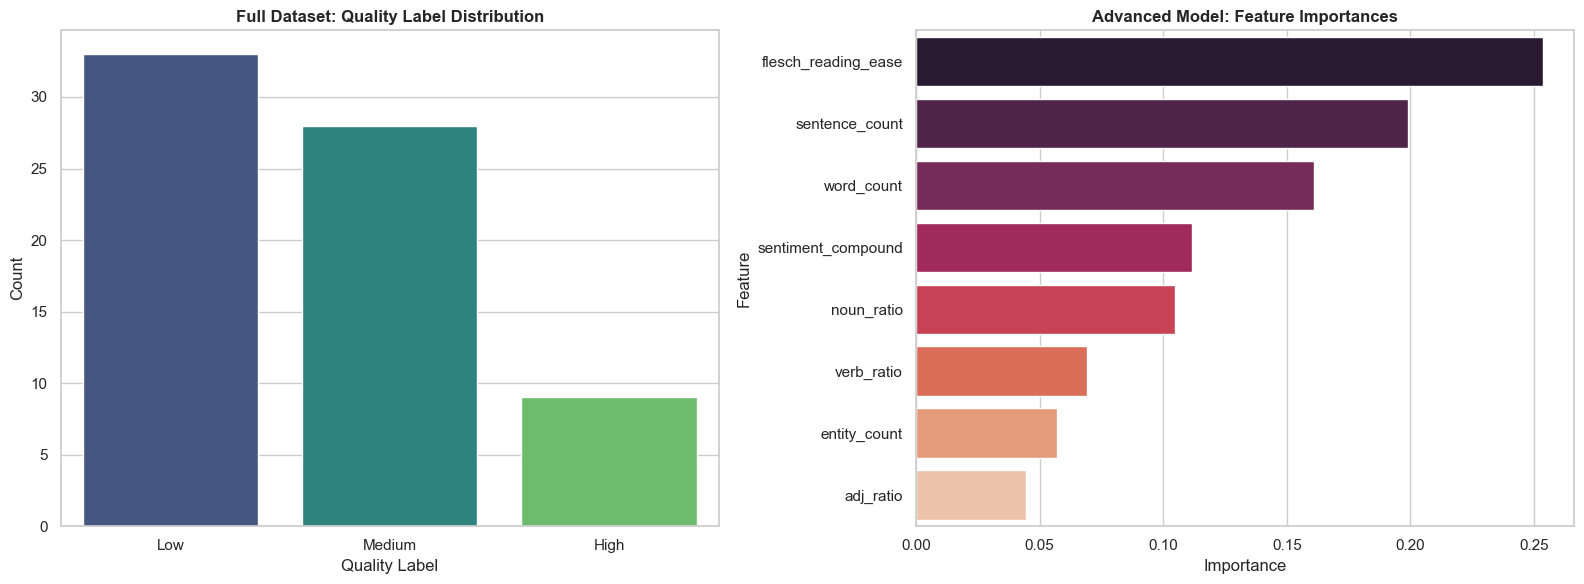

In [16]:
# VISUALIZATIONS (+3 Points)
print("Generating bonus visualizations...")

sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 6))

# --- 1. Label Distribution ---
plt.subplot(1, 2, 1)
sns.countplot(x=y, order=['Low', 'Medium', 'High'], palette="viridis")
plt.title('Full Dataset: Quality Label Distribution', fontweight='bold')
plt.xlabel('Quality Label')
plt.ylabel('Count')

# --- 2. Feature Importance (from trained model) ---
plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=feature_imp_df, palette="rocket")
plt.title('Advanced Model: Feature Importances', fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

In [17]:
#  STEP 5 - REAL-TIME ANALYSIS FUNCTION
print("Defining `analyze_url` function...")

# --- Load all artifacts for the function ---
try:
    final_model = pickle.load(open(MODEL_FILE, 'rb'))
    final_vectorizer = pickle.load(open(VECTORIZER_FILE, 'rb'))
    from scipy.sparse import load_npz
    full_tfidf_matrix = load_npz(EMBEDDINGS_FILE)
    all_urls = pd.read_csv(FEATURES_ADVANCED_CSV)['url'].tolist()
    _ANALYSIS_READY = True
    print("All artifacts loaded successfully for real-time analysis.")
except FileNotFoundError as e:
    print(f"\nWARNING: Could not load artifacts. {e}")
    _ANALYSIS_READY = False


def analyze_url(url):
    """
    Performs the full end-to-end analysis on a single URL.
    This is the function you'll use in your Streamlit app.
    """
    if not _ANALYSIS_READY:
        return {'error': 'Analysis function not ready. Artifacts missing.'}
    
    print(f"\n--- Analyzing New URL: {url} ---")
    
    try:
        # --- 1. Scrape & Parse ---
        html = fetch_html(url, delay=0) # No delay for real-time
        if not html: return {'error': 'Failed to fetch URL'}

        title, body = extract_title_and_body(html)
        if not body: return {'error': 'Failed to extract content'}

        clean_text = re.sub(r'\s+', ' ', body).strip().lower()

        # --- 2. Extract ALL Features ---
        # Basic features
        wc = len(clean_text.split())
        sc = len(nltk.sent_tokenize(clean_text)) if clean_text else 0
        flesch = textstat.flesch_reading_ease(clean_text)

        # Advanced NLP features
        nlp_features = advanced_nlp_analysis(clean_text)

        # --- 3. Predict Quality ---
        # Create feature vector in the *exact* order as training
        features_vector = [[
            wc,
            sc,
            flesch,
            nlp_features['sentiment_compound'],
            nlp_features['entity_count'],
            nlp_features['noun_ratio'],
            nlp_features['verb_ratio'],
            nlp_features['adj_ratio']
        ]]

        quality_label = final_model.predict(features_vector)[0]
        print(f"Predicted Quality: {quality_label}")

        # --- 4. Find Similar (using TF-IDF) ---
        url_tfidf_vector = final_vectorizer.transform([clean_text])
        sim_scores = cosine_similarity(url_tfidf_vector, full_tfidf_matrix)[0]
        top_indices = sim_scores.argsort()[-3:][::-1]

        similar_to = []
        for idx in top_indices:
            if sim_scores[idx] > 0.1: # Only show meaningful similarity
                similar_to.append({
                    'url': all_urls[idx],
                    'similarity': round(float(sim_scores[idx]), 4)
                })
        print(f"Found {len(similar_to)} similar pages.")

        # --- 5. Assemble Final JSON ---
        result = {
            "url": url,
            "title": title,
            "word_count": wc,
            "readability": round(flesch, 2),
            "quality_label": quality_label,
            "is_thin": wc < 500,
            "sentiment": nlp_features['sentiment_label'],
            "entity_count": nlp_features['entity_count'],
            "similar_to": similar_to
        }
        return result
    
    except Exception as e:
        return {'error': str(e), 'message': 'Failed during analysis pipeline.'}

print("\n`analyze_url` function is ready.")

Defining `analyze_url` function...
All artifacts loaded successfully for real-time analysis.

`analyze_url` function is ready.


In [18]:
# TEST REAL-TIME ANALYSIS

# --- Test 1: A URL from your original dataset (should have 1.0 similarity) ---
if _ANALYSIS_READY and all_urls:
    try:
        TEST_URL_1 = all_urls[0] # Get the first URL from the dataset
        analysis_1 = analyze_url(TEST_URL_1)
        print("\n--- RESULT 1 (JSON) ---")
        print(json.dumps(analysis_1, indent=2))
    except Exception as e:
        print(f"Test 1 failed: {e}")
else:
    print("Skipping Test 1: Analysis artifacts not loaded.")


# --- Test 2: A new, external URL ---
print("\n" + "="*50 + "\n")
TEST_URL_2 = "https://en.wikipedia.org/wiki/Search_engine_optimization"
try:
    analysis_2 = analyze_url(TEST_URL_2)
    print("\n--- RESULT 2 (JSON) ---")
    print(json.dumps(analysis_2, indent=2))
except Exception as e:
    print(f"Test 2 failed: {e}")


--- Analyzing New URL: https://www.varonis.com/blog/cybersecurity-tips ---


C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Quality: Medium
Found 3 similar pages.

--- RESULT 1 (JSON) ---
{
  "url": "https://www.varonis.com/blog/cybersecurity-tips",
  "title": "Top 10 Cybersecurity Awareness Tips: How to Stay Safe and Proactive",
  "word_count": 1652,
  "readability": 41.33,
  "quality_label": "Medium",
  "is_thin": false,
  "sentiment": "Positive",
  "entity_count": 0,
  "similar_to": [
    {
      "url": "https://www.varonis.com/blog/cybersecurity-tips",
      "similarity": 1.0
    },
    {
      "url": "https://www.connectwise.com/blog/phishing-prevention-tips",
      "similarity": 0.4287
    },
    {
      "url": "https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home",
      "similarity": 0.41
    }
  ]
}



--- Analyzing New URL: https://en.wikipedia.org/wiki/Search_engine_optimization ---
Predicted Quality: High
Found 3 similar pages.

--- RESULT 2 (JSON) ---
{
  "url": "https://en.wikipedia.org/wiki/Search_engine_optimization",
  "title": "Search eng

C:\Users\Admin\Desktop\seo-content-detector\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
